In [428]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from numpy import linalg as LA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import check_pairwise_arrays

# Summary

Implementation of simple Gaussian process regression using [1], [2] & [3].

[1] Williams, C. K., & Rasmussen, C. E. (2006). Gaussian processes for machine learning (Vol. 2, No. 3, p. 4). Cambridge, MA: MIT Press.

[2] Grunewalder, S. (2010). Gaussian Processes: Basic Properties and GP Rgressions. University College London.

[3] Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

# Gaussian Processes

Given observed inputs $\mathbf{x}_{i}$ and outputs $y_{i}$ where the outputs are some unknown function of the inputs $y_{i} = f(\mathbf{x}_{i})$, possibly with added noise. A distribution over functions can then be inferred given the data, $p(f|\mathbf{X},\mathbf{y})$. The posterior predictive distribution

$$
p\left(y_{*} | \mathbf{x}_{*}, \mathbf{X}, \mathbf{y}\right)=\int p\left(y_{*} | f, \mathbf{x}_{*}\right) p(f | \mathbf{X}, \mathbf{y}) df
$$

can then be used to make predictions given new inputs. Where $\mathbf{x}_{*}$ are the new inputs and $y_{*}$ are the predicted outputs.

## GP's for regression

The prior on the regression function is a GP,

$$
f(\mathbf{x}) \sim G P\left(m(\mathbf{x}), k\left(\mathbf{x}, \mathbf{x}^{\prime}\right)\right)
$$

Where $m(\mathbf{x})$ is the mean function and $k(\mathbf{x},\mathbf{x}')$ is the covariance function

$$
\begin{aligned} m(\mathbf{x}) &=\mathbb{E}[f(\mathbf{x})] \\ k\left(\mathbf{x}, \mathbf{x}^{\prime}\right) &=\mathbb{E}\left[(f(\mathbf{x})-m(\mathbf{x}))\left(f\left(\mathbf{x}^{\prime}\right)-m\left(\mathbf{x}^{\prime}\right)\right)^{T}\right] \end{aligned}
$$

where $k()$ is a positive definite kernel. For any finite set of points this process defined a joint Gaussian

$$
p(\mathbf{f} | \mathbf{X})=\mathcal{N}(\mathbf{f} | \boldsymbol{\mu}, \mathbf{K})
$$

where $K_{i j}=k\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)$ and $\boldsymbol{\mu}=\left(m\left(\mathbf{x}_{1}\right), \ldots, m\left(\mathbf{x}_{N}\right)\right)$.

## Generate some data for GP regression.

In [429]:
# draw 10 random numbers from a uniform distribution between 0 and 2pi
N = 10
beta = 5
x = np.random.uniform(low=0.0, high=4*np.pi, size=N)
x = np.sort(x)
# generate some targets with Gaussian noise
fx = np.sin(x)
y = np.random.normal(fx,1/beta,N)
# actual data for comparison
x_act = np.linspace(0,4*np.pi,100)
y_act = np.sin(x_act)

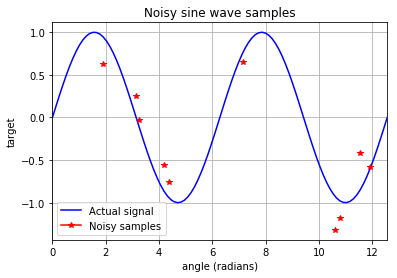

In [430]:
# plot the sample targets and the true signal
fig, ax = plt.subplots()
ax.plot(x_act, y_act, color='blue')
ax.plot(x, y, '*', color='red')
blue = mlines.Line2D([], [], color='blue', label='Actual signal')
red = mlines.Line2D([], [], color='red', label='Noisy samples', marker='*')
plt.legend(handles=[blue, red])
ax.set(xlabel='angle (radians)', ylabel='target',
       title='Noisy sine wave samples')
ax.autoscale(enable=True, axis='x', tight=True)
ax.grid()
plt.show()

The kernel function used here is the Gaussian radial basis function

$$
k\left(x, x^{\prime}\right)= \exp \left(-\gamma||x-x^{\prime}||^{2}\right).
$$

## Sample from the GP

We can now draw sample functions from the prior using the kernel function with the following steps [2]:

- Compute the Cholesky decomposition of the gram matrix, $\mathbf{K}_y=\mathbf{K}+\sigma_y^2\mathbf{I}$

$$Cholesky(\mathbf{K}+\sigma_y^2\mathbf{I})= \mathbf{L}$$

  where the $\sigma_y^2$ is for numerical precision. $\mathbf{K}_y$ is recovered with,

$$\mathbf{K}_{y}=\mathbf{L}\mathbf{L}^T$$
- Generate 
$$\mathbf{u}\sim\mathcal{N}(0,\mathbf{I})$$
- Compute the sample trajectory
$$\mathbf{x} = \mathbf{\mu} + \mathbf{L.u}$$

Here $\mu$ is assumed to be zero.

In [431]:
def rbf_kernel(X, Y=None, gamma=None, eval_gradient=False):
    """
    Compute the rbf (gaussian) kernel between X and Y::
        K(x, y) = exp(-gamma ||x-y||^2)
    for each pair of rows x in X and y in Y.
    Read more in the :ref:`User Guide <rbf_kernel>`.
    Parameters
    ----------
    X : array of shape (n_samples_X, n_features)
    Y : array of shape (n_samples_Y, n_features)
    gamma : float, default None
        If None, defaults to 1.0 / n_features
    Returns
    -------
    kernel_matrix : array of shape (n_samples_X, n_samples_Y)
    """
    X, Y = check_pairwise_arrays(X, Y)
    if gamma is None:
        gamma = 1.0 / X.shape[1]

    sqdist = euclidean_distances(X, Y, squared=True)
    
    K = np.exp(-gamma*sqdist)
    
    if eval_gradient:        
        K_gradient = -sqdist * K
        return K, K_gradient
    else:
        return K

In [432]:
n = 100
x_test = np.linspace(0,4*np.pi,n).reshape(n,1)
x_test.shape

K = rbf_kernel(x_test,x_test,gamma=1)
# Cholesky decomposition
L = LA.cholesky(K+1e-8*np.eye(n))
# draw sample trajectories from the prior
prior_sample = np.dot(L, np.random.normal(size=(n,4)))


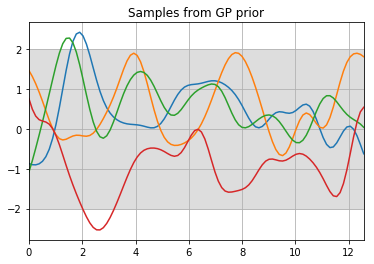

In [433]:
# plot the sample trajectories from the prior
fig, ax = plt.subplots()
ax.plot(x_test,prior_sample)
plt.gca().fill_between(x_s.flat, -2, 2, color="#dddddd")
ax.set(title='Samples from GP prior')
ax.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

# Posterior predictive with noisy observations

Considering the case where the observations are a noisy version of the underlying function, $y = f(\mathbf{x})+\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma_y^2)$. Here $f(\mathbf{x})$ is a latent noise free function that is unknown. The covariance of the observed noisy responses is,

$$cov[y_n, y_m] = k(\mathbf{x}_n,\mathbf{x}_n) + \sigma_y^2\delta_{nm}$$

where $\delta_{nm} = \mathbb{1}(n=m)$. In matrix form this equation becomes,

$$cov[\mathbf{y}|\mathbf{X}]=\mathbf{K}+\sigma_y^2\mathbf{I}=\mathbf{K}_y$$

where $\mathbf{K}=\kappa(\mathbf{X},\mathbf{X})$ is $N\times N$. The second matrix is diagonal because the noise terms are independently added to each observation. 

The joint density of the observed data and the latent, noise-free function on the test points is given by

$$\begin{pmatrix}
\mathbf{y}\\
\mathbf{f}_{*}\\
\end{pmatrix}=
\mathcal{N}\Bigg(\mathbf{0},
\begin{pmatrix}
\mathbf{K}_y & \mathbf{K}_{*}\\
\mathbf{K}_{*}^{T} & \mathbf{K}_{**}\\
\end{pmatrix}
\Bigg)
$$

where $\mathbf{K}_{*}=\kappa(\mathbf{X},\mathbf{X}_{*})$ is $N \times N_{*}$, $\mathbf{K}_{**}=\kappa\left(\mathbf{X}_{*}, \mathbf{X}_{*}\right)$ is $N_{*} \times N_{*}$. The posterior predictive density is then

$$
\begin{aligned} p\left(\mathbf{f}_{*} | \mathbf{X}_{*}, \mathbf{X}, \mathbf{y}\right) &=\mathcal{N}\left(\mathbf{f}_{*} | \boldsymbol{\mu}_{*}, \mathbf{\Sigma}_{*}\right) \\ \boldsymbol{\mu}_{*} &=\mathbf{K}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{y} \\ \boldsymbol{\Sigma}_{*} &=\mathbf{K}_{* *}-\mathbf{K}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{K}_{*} \end{aligned}
$$

In the case of a single test input this simplifies to,

$$
p\left(f_{*} | \mathbf{x}_{*}, \mathbf{X}, \mathbf{y}\right)=\mathcal{N}\left(f_{*} | \mathbf{k}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{y}, k_{* *}-\mathbf{k}_{*}^{T} \mathbf{K}_{y}^{-1} \mathbf{k}_{*}\right)
$$

where, $\mathbf{k}_{*}=\left[\kappa\left(\mathbf{x}_{*}, \mathbf{x}_{1}\right), \ldots, \kappa\left(\mathbf{x}_{*}, \mathbf{x}_{N}\right)\right]$ and $k_{* *}=\kappa\left(\mathbf{x}_{*}, \mathbf{x}_{*}\right)$

![title](imgs/gp-regression-algorithm.png)
Source [3]

In [455]:
# training variables are x and y
# evaluation points
N = 100
gamma = 1.52902779
x = x.reshape(-1,1)
x_s = np.linspace(0,4*np.pi,N).reshape(-1,1)

# kernel K
K = rbf_kernel(x,x,gamma=gamma)
# Cholesky decomposition
L = LA.cholesky(K+1e-5*np.eye(len(x)))
alpha = LA.solve(L.T, LA.solve(L, y))

# kernel K*
K_s = rbf_kernel(x,x_s,gamma=gamma)

# mean of the posterior
mu = np.dot(K_s.T, alpha)

# variance of the posterior
K_ss = rbf_kernel(x_s,x_s,gamma=gamma)
v = LA.solve(L, K_s)
var = np.diag(K_ss) - np.sum(v ** 2, axis=0)
stdv = np.sqrt(var)

# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

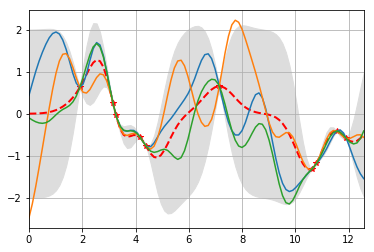

In [456]:
# plot the results
plt.figure(1)
plt.plot(x, y, '*', color='red') # training data
plt.plot(x_s, mu,  'r--', lw=2)
plt.plot(x_s, f_post)
plt.gca().fill_between(x_s.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
#ax.set(xlabel='angle (radians)', ylabel='target',
#       title='Noisy sine wave samples')
plt.show()


## Sections to follow not yet correctly working

## Maximum Likelihood of the Hyper-parameters

The marginal likelihood (or evidence) for the Gaussian process is given by the equation

$$
\log p(\mathbf{y} | X, \boldsymbol{\theta})=-\frac{1}{2} \mathbf{y}^{\top} K_{y}^{-1} \mathbf{y}-\frac{1}{2} \log \left|K_{y}\right|-\frac{n}{2} \log 2 \pi
$$

where $K_{y}=K_{f}+\sigma_{n}^{2} I$ is the covariance matrix for the noisy targets $\mathbf{y}$. The three terms of the marginal likelihood have interpretable roles: 

1. The only term involving the the observed targets is the data fit term $-\frac{1}{2}\mathbf{y}^{\top} K_{y}^{-1} \mathbf{y}$ 


2. $\frac{1}{2}\log \left|K_{y}\right|$ is the complexity penalty depending only on the covariance function and the inputs.


3. $\frac{n}{2} \log (2 \pi)$ is a normalising constant.


The marginal log likelihood is implemented according to the formula in algorithm 15.1 above.

To set the hyperparameters by maximising the marginal likelihood, we need the partial derivatives of the marignal likelihood with respect to $\gamma$

$$
\begin{aligned} \frac{\partial}{\partial \theta_{j}} \log p(\mathbf{y} | X, \boldsymbol{\theta}) &=\frac{1}{2} \mathbf{y}^{\top} K^{-1} \frac{\partial K}{\partial \theta_{j}} K^{-1} \mathbf{y}-\frac{1}{2} \operatorname{tr}\left(K^{-1} \frac{\partial K}{\partial \theta_{j}}\right) \\ &=\frac{1}{2} \operatorname{tr}\left(\left(\boldsymbol{\alpha} \boldsymbol{\alpha}^{\top}-K^{-1}\right) \frac{\partial K}{\partial \theta_{j}}\right) \text { where } \boldsymbol{\alpha}=K^{-1} \mathbf{y} \end{aligned}.
$$

Where,
$$
\frac{\partial K}{\partial \theta_{j}}=\frac{\partial}{\partial \gamma}\left(\exp \left(-\gamma\|x-y\|^{2}\right)\right)=-\|x-y\|^{2}\left(e^{-\gamma\|x-y\|^{2}}\right)
$$

In [457]:
def cholesky_inverse(A):
    L = LA.cholesky(A)
    u = LA.solve(L,np.eye(A.shape[0]))
    A_inv = LA.solve(L.T,u)
    return A_inv

In [458]:
def log_marginal_likelihood(gamma, x_train, y_train, eval_gradient=False):
    
    # kernel K
    K, K_gradient = rbf_kernel(x_train,x_train,gamma=gamma,eval_gradient=True)
    
    # Cholesky decomposition
    L = LA.cholesky(K+1e-8*np.eye(len(x_train)))
    alpha = LA.solve(L.T, LA.solve(L, y))# Line 3

    # Compute marginal log-likelihood
    data_fit = -0.5 * np.dot(y_train.T, alpha)
    complexity = -np.log(np.diag(L)).sum()
    constant = -K.shape[0] / 2 * np.log(2 * np.pi)
    log_likelihood = data_fit + complexity + constant  
    
    # Compute gradient of marginal log-likelihood
    if eval_gradient: 
        tmp = np.dot(alpha, alpha.T) - cholesky_inverse(K)
        log_likelihood_gradient = 05. * np.trace(np.dot(tmp, K_gradient))
    
    if eval_gradient:
        return -log_likelihood, log_likelihood_gradient
    else:
        return -log_likelihood

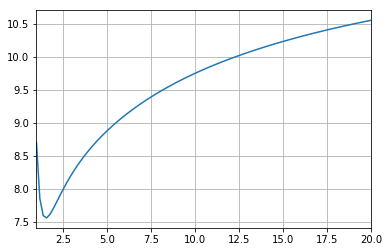

In [459]:
gamma = np.linspace(1,20,100)
ll = []

for g in gamma:
    log_lik = log_marginal_likelihood(g,x,y,eval_gradient=False)
    ll.append(log_lik)
    
plt.figure(1)
plt.plot(gamma, ll) # training data
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
# plt.yscale("log")
plt.show()

## Use conjugate gradient optimisation to determine hyper-parameter values



In [460]:
from scipy.optimize import fmin_cg
args = (x, y, False)
x0=1
fmin_cg(log_marginal_likelihood, x0=x0, fprime=None, args=args)

Optimization terminated successfully.
         Current function value: 7.555415
         Iterations: 1
         Function evaluations: 27
         Gradient evaluations: 9


array([1.52902779])